### Initial Implementation

##### 1. Imports

In [1]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset

import re
import emoji
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

##### 2. Load Dataset

In [2]:
# load dataset.
# HF_TOKEN has been set in .env
data = load_dataset("shainar/BEAD", "Full_Annotations", split="full")
print(data)

Dataset({
    features: ['text', 'dimension', 'biased_words', 'aspect', 'label', 'sentiment', 'toxic', 'identity_mention'],
    num_rows: 3674927
})


In [3]:
# convert to pandas dataframe.
df = data.to_pandas()
df = df.rename(columns={"label": "bias"})
print(df.head())

                                                text             dimension  \
0  Where will this leave the kids??? That my frie...  Ageism and sentiment   
1   I had a feeling of impending doom &amp; then ...  Ageism and sentiment   
2                                 I no feel good ..   Ageism and sentiment   
3  Back in Hotlanta for a about a week, then off ...  Ageism and sentiment   
4  Kids toys &amp; stamping stuff cleaned up... N...  Ageism and sentiment   

            biased_words          aspect             bias sentiment  toxic  \
0                     []     Transphobia  Slightly Biased  Negative    0.0   
1  ['impending', 'doom']  Climate change    Highly Biased  Negative    1.0   
2                     []    Body-shaming          Neutral  Positive    0.0   
3                     []       Lifestyle  Slightly Biased  Negative    0.0   
4                     []           Hobby          Neutral   Neutral    1.0   

  identity_mention  
0               NO  
1               NO  

In [4]:
# retain necessary columns.
df = df.drop(['dimension', 'aspect', 'identity_mention'], axis=1)
print(df.shape)

(3674927, 5)


##### 3. Text Pre-processing

In [5]:
# number of empty data items by attribute.
print(df.isnull().sum())

text            2
biased_words    0
bias            0
sentiment       0
toxic           0
dtype: int64


In [6]:
# drop blank texts.
before = len(df)
df = df.dropna(subset=['text'])
after = len(df)
print(f"Dropped {before - after} rows.")

Dropped 2 rows.


In [7]:
# drop duplicate rows.
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Dropped {before - after} rows.")

Dropped 89 rows.


In [8]:
# convert text to 'string'.
df['text'] = df['text'].astype(str)

In [9]:
# clean text.
text = df['text']
text = text.apply(lambda x: x.lower())

def edit(text):
	text = emoji.demojize(text).replace(":", "").replace("_", " ")                # convert emojis to words
	text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text)   # remove HTML tags and entities
	text = re.sub(r'https?://\S+|www\.\S+', '', text)                             # remove URLs
	text = re.sub(r'[^a-z0-9\s.,!?]', '', text)                                   # remove special characters
	text = re.sub(r'\s+', ' ', text).strip()                                      # collapse spaces
	return text

text = text.apply(edit)
df['text'] = text

In [10]:
# find range of text lengths.
df["text_length"] = df["text"].str.len()
desc = df["text_length"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(desc)

count    3.674836e+06
mean     2.044592e+02
std      2.817722e+02
min      0.000000e+00
25%      5.600000e+01
50%      1.050000e+02
75%      2.350000e+02
90%      5.310000e+02
95%      7.950000e+02
99%      9.890000e+02
max      3.219100e+04
Name: text_length, dtype: float64


In [11]:
# print record with longest text.
ind = df["text_length"].idxmax()
row = df.loc[ind]
print(row)

text            i am writing this article for an audience cons...
biased_words    ['discrimination', 'is racist', 'genuinely', '...
bias                                                Highly Biased
sentiment                                                Negative
toxic                                                         0.0
text_length                                                 32191
Name: 2316716, dtype: object


In [12]:
# drop texts with length < 10.
min_len = 10
ind_drop = df[df['text'].str.len() < min_len].index
print(f"Dropped {len(ind_drop)} rows.")
df.drop(ind_drop, inplace=True)

Dropped 12025 rows.


In [13]:
# drop texts with length > 512.
max_len = 512
ind_drop = df[df['text'].str.len() > max_len].index
print(f"Dropped {len(ind_drop)} rows.")
df.drop(ind_drop, inplace=True)

Dropped 386651 rows.


##### 4. Dataset Characteristics

In [14]:
# number of rows.
print(f"{len(df)} rows.")

3276160 rows.


In [15]:
# processed text length range.
desc = df["text_length"].describe()
print(desc)

count    3.276160e+06
mean     1.302522e+02
std      1.115828e+02
min      1.000000e+01
25%      5.300000e+01
50%      9.300000e+01
75%      1.590000e+02
max      5.120000e+02
Name: text_length, dtype: float64


In [16]:
# class distribution of 'bias'.
print(df['bias'].value_counts())

bias
Neutral            1825543
Slightly Biased     922334
Highly Biased       528283
Name: count, dtype: int64


In [17]:
# class distribution of 'sentiment'.
print(df['sentiment'].value_counts())

sentiment
Positive    1470644
Negative    1050002
Neutral      755514
Name: count, dtype: int64


In [18]:
# class distribution of 'toxic'.
print(df['toxic'].value_counts())

toxic
0.0    2145755
1.0    1130405
Name: count, dtype: int64


##### 5. Encoding Categorical Columns

In [19]:
# encode categorical columns.
y = pd.DataFrame(data)
target_columns = ['bias', 'sentiment', 'toxic']

encoders = {}
for col in target_columns:
  encoder = LabelEncoder()
  df[col] = encoder.fit_transform(df[col])
  encoders[col] = encoder
  print("Mapping:", dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

Mapping: {'Highly Biased': np.int64(0), 'Neutral': np.int64(1), 'Slightly Biased': np.int64(2)}
Mapping: {'Negative': np.int64(0), 'Neutral': np.int64(1), 'Positive': np.int64(2)}
Mapping: {np.float64(0.0): np.int64(0), np.float64(1.0): np.int64(1)}


In [20]:
# print encoded dataset.
print(df.head())

                                                text           biased_words  \
0  where will this leave the kids??? that my frie...                     []   
1  i had a feeling of impending doom then hear ab...  ['impending', 'doom']   
2                                  i no feel good ..                     []   
3  back in hotlanta for a about a week, then off ...                     []   
4  kids toys stamping stuff cleaned up... next ki...                     []   

   bias  sentiment  toxic  text_length  
0     2          0      0           78  
1     0          0      1           73  
2     1          2      0           17  
3     2          0      0          133  
4     1          1      1           99  


##### 6. Resampling

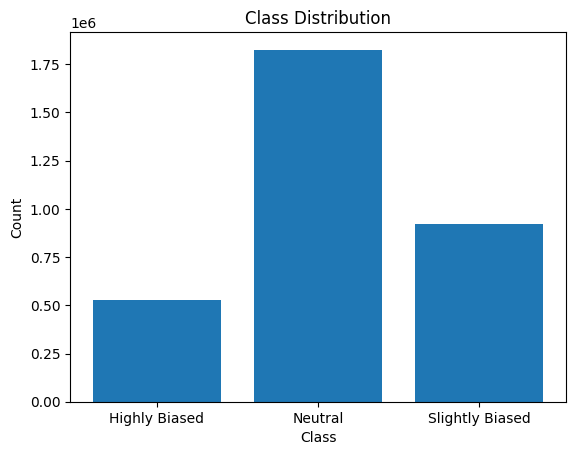

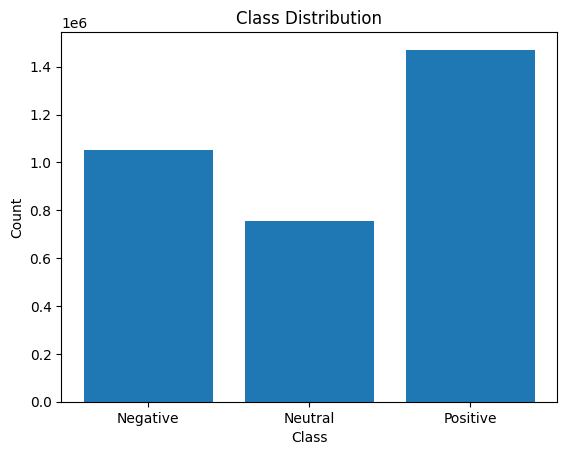

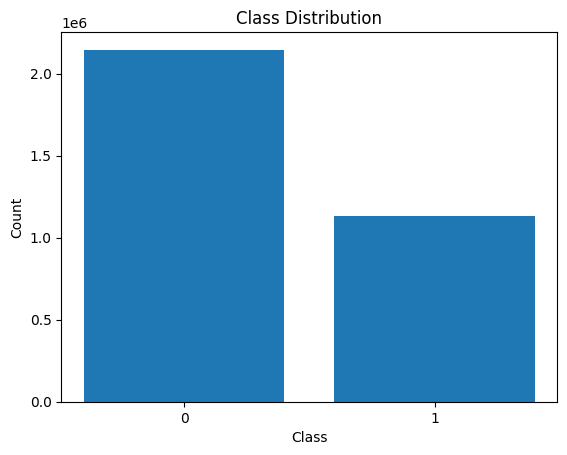

In [21]:
y_col = ["bias", "sentiment", "toxic"]
y_vals = [["Neutral", "Slightly Biased", "Highly Biased"], ["Positive", "Negative", "Neutral"], ["0", "1"]]
for i in range(len(y_col)):
  y = df[y_col[i]]
  count_class = y.value_counts()
  plt.bar(count_class.index, count_class.values)
  plt.xlabel('Class')
  plt.ylabel('Count')
  plt.title('Class Distribution')
  plt.xticks(count_class.index, y_vals[i])
  plt.show()

In [22]:
# Mapping from numeric IDs to labels
bias_map = {
    0: "Highly Biased",
    1: "Neutral",
    2: "Slightly Biased"
}

sentiment_map = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}

toxic_map = {
    0.0: 0.0,
    1.0: 1.0
}

# Target ratios (semi-balanced)
bias_weights = {
    "Neutral": 0.40,
    "Slightly Biased": 0.35,
    "Highly Biased": 0.25
}

sentiment_weights = {
    "Positive": 0.38,
    "Negative": 0.32,
    "Neutral": 0.30
}

toxic_weights = {
    0.0: 0.60,
    1.0: 0.40
}

# Create joint label
df["joint_label"] = list(zip(df["bias"], df["toxic"], df["sentiment"]))

# Check original distribution
print("Before rebalancing:\n", df["joint_label"].value_counts())

# Base size = total dataset size
base_target_size = len(df)

balanced_parts = []
for label, count in df["joint_label"].value_counts().items():
    b, t, s = label

    # Map IDs to names
    b_label = bias_map[b]
    s_label = sentiment_map[s]
    t_label = toxic_map[t]

    # Compute joint weight
    weight = (
        bias_weights[b_label] *
        toxic_weights[t_label] *
        sentiment_weights[s_label]
    )

    # Target number of samples for this joint class
    target_n = int(base_target_size * weight)

    subset = df[df["joint_label"] == label]

    if count > target_n:
        # Undersample majority class
        subset_balanced = resample(
            subset,
            replace=False,
            n_samples=target_n,
            random_state=42
        )
    else:
        # Oversample minority class
        subset_balanced = resample(
            subset,
            replace=True,
            n_samples=target_n,
            random_state=42
        )

    balanced_parts.append(subset_balanced)

# Combine everything
balanced_df = pd.concat(balanced_parts).reset_index(drop=True)

print("\n---------------------------------------------------\n")
print("After rebalancing:\n", balanced_df["joint_label"].value_counts())
print("\nBias:\n", balanced_df["bias"].value_counts())
print("\nSentiment:\n", balanced_df["sentiment"].value_counts())
print("\nToxic:\n", balanced_df["toxic"].value_counts())
print("\nFinal Shape:", balanced_df.shape)

Before rebalancing:
 joint_label
(1, 0, 2)    895607
(1, 0, 1)    497735
(2, 0, 0)    330421
(0, 1, 0)    308690
(1, 1, 2)    247120
(2, 1, 0)    216294
(0, 0, 0)    194597
(1, 1, 1)    185081
(2, 0, 2)    179840
(2, 1, 2)    125099
(2, 0, 1)     35729
(2, 1, 1)     34951
(0, 1, 2)     11984
(0, 0, 2)     10994
(0, 1, 1)      1186
(0, 0, 1)       832
Name: count, dtype: int64

---------------------------------------------------

After rebalancing:
 joint_label
(1, 0, 2)    298785
(2, 0, 2)    261437
(1, 0, 1)    235883
(2, 0, 0)    220157
(2, 0, 1)    206398
(1, 1, 2)    199190
(0, 0, 2)    186741
(2, 1, 2)    174291
(0, 0, 0)    157255
(1, 1, 1)    157255
(0, 0, 1)    147427
(2, 1, 0)    146771
(2, 1, 1)    137598
(0, 1, 2)    124494
(0, 1, 0)    104837
(0, 1, 1)     98284
Name: count, dtype: int64

Bias:
 bias
2    1146652
1     891113
0     819038
Name: count, dtype: int64

Sentiment:
 sentiment
2    1244938
1     982845
0     629020
Name: count, dtype: int64

Toxic:
 toxic
0    171

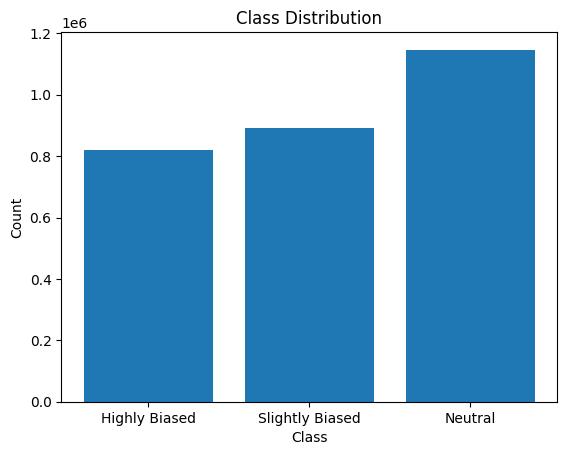

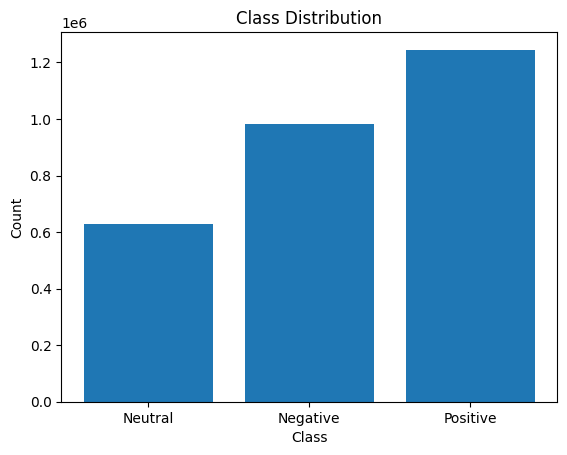

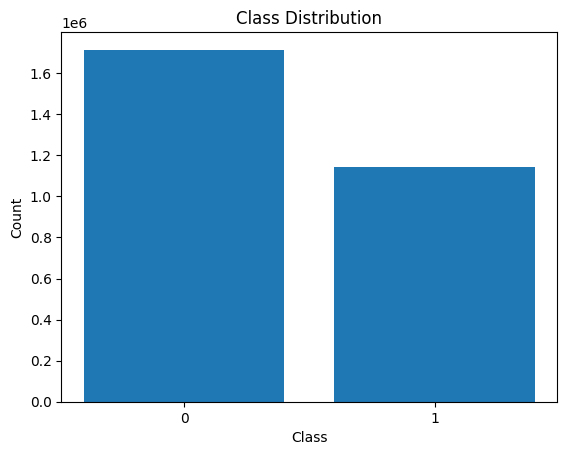

In [23]:
y_col = ["bias", "sentiment", "toxic"]
y_vals = [["Neutral", "Slightly Biased", "Highly Biased"], ["Positive", "Negative", "Neutral"], ["0", "1"]]
for i in range(len(y_col)):
  y = balanced_df[y_col[i]]
  count_class = y.value_counts()
  plt.bar(count_class.index, count_class.values)
  plt.xlabel('Class')
  plt.ylabel('Count')
  plt.title('Class Distribution')
  plt.xticks(count_class.index, y_vals[i])
  plt.show()

In [24]:
print(balanced_df)

                                                      text  \
0        im okay with it being there and im not religious.   
1        nn chchchchina nnlets dialogue about this wond...   
2        ianbetteridge firefox2, no idea what version o...   
3        so kool!i didnt know he came to alaska.i was 1...   
4        catwoman123 if you know the real demi moore an...   
...                                                    ...   
2856798  i see that someone answered on your talk page....   
2856799  sheriff joe as you affectionately call him had...   
2856800  your incredulity doesnt make your claim any mo...   
2856801  find someone elses comment to spew your islamo...   
2856802  your link is an interesting read and very bala...   

                                         biased_words  bias  sentiment  toxic  \
0                                                  []     1          2      0   
1                                                  []     1          2      0   
2           